<a href="https://colab.research.google.com/github/Br4ggs/DecisionTheory/blob/main/mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision theory mini-project

In this project we are going to explore the concept of a Markovian Decision Process by using Utility Theory. We will create a rational agent that performs tasks in a simple world.

## Initial concept
Our initial concept was to use `OpenAI gym` to create a simple agent for the classic `pendulum` problem, in which an actor must swing a pendulum from left to right by applying directional force to it.

Perhaps we will come back to this idea later, for this notebook we will be creating a simple world and actor from scratch.

We started with these initial ideas for our problem:
* delivery truck (some short roads might have traffic jams)  
* minesweeper  
* frozen lake (you don't always move in the intended direction)
* blackjack

These inspired us to come up with the following concept for the problem:

You are a delivery driver tasked with delivering cargo to a set of locations. Additionally, you will have to do this in as short of a time as possible. Luckily you know this place like the back of your hand and know a couple of shortcuts which can decrease your time. Careful however, since you aren't the only one that knows these shortcuts,there's a chance you might run into a traffic jam, severely increasing your time.

## Imports and necessary functions
We start by importing the libraries that we will be using, as well as defining some functions that will be used later on.

In [ ]:
import random
from enum import Enum
import copy
from itertools import chain, combinations
from __future__ import annotations

def powerset(iterable):
    s = list(iterable)
    subsets = []
    for subset in chain.from_iterable(combinations(s, r) for r in range(len(s)+1)):
      subsets.append(list(subset))
    return subsets

def LocationToIndex(column: int, row: int, widht: int) -> int:
    return  row * width + column

## Action space
We start by defining the action space for our world. In this world the agent will act as a delivery truck that can move between places and deliver cargo. The action space will therefore looks as follows:

Actions:
*  Up
*  Down
*  Left
*  Right
*  Deliver

Actions `Up`, `Down`, `Left`, and `Right` all move the actor to a new position. `Deliver` is unique in that it does not move the truck, but will drop off cargo at the current position.

In [ ]:
class Action(Enum):
    Up = 1
    Down = 2
    Left = 3
    Right = 4
    Deliver = 5

    def __str__(self):
        return self.name

## Model definition
We constructed our model out of 3 different classes: `Intersection`, `Road`, and `Truck`: 

An `Intersection` is a location on our grid based environment. It has three attributes: It's `row`, `column` and wheter it has a `delivery requirement`. This requirment is used to check if we should deliver cargo to this location.

A `Road` is a connection between 2 intersections, and used by the agent to travel from one point to another. It has three attributes: It's `intersectionA` and `intersectionB` signify the 2 endpoints. `probability` stores the probability of this road having a traffic jam.

Finally, a `Truck` is the current state the world is in. It has two attributes: It's `location` currently in the world and `deliveries` which is the required deliveries still left.

In [ ]:
class Intersection:
  __row: int
  __column: int
  __delivery_amount_required: float

  def __init__(self, delivery_amount_required: float):
      self.__delivery_amount_required = delivery_amount_required

  def get_delivery_amount_required(self) -> float:
      return self.__delivery_amount_required

  def requires_delivery(self) -> bool:
      return self.__delivery_amount_required > 0

  def get_row(self) -> int:
      return self.__row

  def get_column(self) -> int:
      return self.__column
    
  def set_location(self, column: int, row: int):
      self.__row = row
      self.__column = column

  def deliver(self):
      self.__delivery_amount_required = 0

  def __str__(self):
      return "({},{})".format(self.__column, self.__row)

  def __hash__(self):
    return hash((self.__delivery_amount_required, self.__column, self.__row))

  def __eq__(self, other: Intersection):
    if isinstance(other, Intersection):
      return self.__row == other.get_row() and self.__column == other.get_column()
    else:
      return False

class Road:
    __intersectionA: Intersection = None
    __intersectionB: Intersection = None
    __probability: float = 0

    def __init__(self, probability: float, intersectionA: Intersection, intersectionB: Intersection):
        self.__probability = probability
        self.__intersectionA = intersectionA
        self.__intersectionB = intersectionB

    def get_traffic_probability(self) -> float:
        return self.__probability

    def get_intersection_A(self):
        return self.__intersectionA

    def get_intersection_B(self):
        return self.__intersectionB

    def is_endpoint(self, intersection: Intersection) -> bool:
        return self.get_intersection_A() == intersection or self.get_intersection_B() == intersection
    
    def __str__(self):
        return "({}, {}, {})".format(str(self.__intersectionA), str(self.__intersectionB), self.__probability)

    def __hash__(self):
      return hash((self.__probability, self.__intersectionA, self.__intersectionB))


class Truck:
    __location: Intersection
    __deliveries: [Intersection]

    def __init__(self, location: Intersection = None, deliveries: [Intersection] = None):
        self.set_location(location,deliveries)

    def get_location(self) -> Intersection:
        return self.__location

    def get_deliveries(self) -> [Intersection]:
        return self.__deliveries

    def set_location(self, location: Intersection, deliveries: [Intersection]):
        self.__location = location
        self.__deliveries = deliveries
      
    def is_done(self):
      return len(self.__deliveries) == 0

    def __str__(self):
        deliveries = ""
        deliveries += "["
        deliveries += ",".join(map(lambda delivery: str(delivery), self.__deliveries))
        deliveries += "]"

        return "({}, {})".format(str(self.__location), deliveries)


## Environment definition
We encapsulate the aforementioned 3 classes in an `Environment` class which will represent our world. We can take actions in this world to alter it's current state.

Additionally, we use a `RewardModel` class to store the rewards given by certain actions, such as for traffic, no traffic, a good delivery and a bad delivery.

In [ ]:
class RewardModel:
  __reward_traffic: float = 0
  __reward_no_traffic: float = 0
  __reward_delivery: float = 0
  __reward_nothing_to_deliver: float = 0

  def __init__(self, reward_traffic: float, reward_no_traffic: float, reward_delivery: float, reward_nothing_to_deliver: float):
      self.__reward_traffic = reward_traffic
      self.__reward_no_traffic = reward_no_traffic
      self.__reward_delivery = reward_delivery
      self.__reward_nothing_to_deliver = reward_nothing_to_deliver

  def get_reward_traffic(self) -> float:
      return self.__reward_traffic

  def get_reward_no_traffic(self) -> float:
      return self.__reward_no_traffic

  def get_reward_delivery(self) -> float:
      return self.__reward_delivery

  def get_reward_nothing_to_deliver(self) -> float:
      return self.__reward_nothing_to_deliver

class Environment:
  __startIntersection: int

  __intersections: [Intersection]
  __roads: [Road]

  __initial_intersections: [Intersection]
  __initial_roads: [Road]

  __width: int
  __height: int
  __truck: Truck
  __reward_model: RewardModel

  def __init__(self, startIntersection: int, intersections: [Intersection], roads: [Road], width: int, height: int, reward_model: RewardModel):
      self.__startIntersection = startIntersection
      self.__initial_intersections = intersections
      self.__initial_roads = roads

      self.__width = width
      self.__height = height
      self.__truck = Truck()

      for row in range(0, height):
          for column in range(0, width):
              self.__initial_intersections[LocationToIndex(column, row, self.__width)].set_location(column, row)
      
      self.reset()
      self.__reward_model = reward_model
  
  def get_width(self):
    return self.__width
  
  def get_height(self):
    return self.__height
  
  def get_truck(self):
    return self.__truck
  
  def get_intersection(self, column: int, row: int) -> Intersection:
      index = LocationToIndex(column, row, self.__width)
      if index not in range(0, len(self.__intersections)):
          return None
      else:
          return self.__intersections[index]

  def get_road(self, intersectionA: Intersection, intersectionB: Intersection) -> Road:
      if intersectionA == None or intersectionB == None or intersectionA == intersectionB:
        return None

      for road in self.__roads:
          if road.is_endpoint(intersectionA) and road.is_endpoint(intersectionB):
              return road
      return None


  def get_possible_states(self):
    delivery_points = self.get_states_with_delivery_requirement()
    permutations = powerset(delivery_points)

    states = []
    for intersection in self.__intersections:
      for permutation in permutations:
        states.append(Truck(intersection, permutation))

    return states

  def get_states_with_delivery_requirement(self) -> list:
    return list(filter(lambda intersection:  intersection.requires_delivery(), self.__intersections))

  def step(self, action: Action) -> (Truck, float, bool):
      next_location = self.calculate_transition(action, self.__truck)

      reward = self.calculate_reward(action, self.__truck, next_location)
      self.__handle_action(action, next_location)
      done = self.__is_done()
      observation = self.__truck
      return observation, reward, done

  def calculate_transition(self, action: Action, truck: Truck) -> Intersection:
      intersection = truck.get_location()
      next_location = None
      if action == Action.Up:
          next_location = self.get_intersection(intersection.get_column(), intersection.get_row() - 1)
      elif action == Action.Down:
          next_location = self.get_intersection(intersection.get_column(), intersection.get_row() + 1)
      elif action == Action.Left:
          next_location = self.get_intersection(intersection.get_column() - 1, intersection.get_row())
      elif action == Action.Right:
          next_location = self.get_intersection(intersection.get_column() + 1, intersection.get_row())

      if next_location == None:
        return intersection
      else:
        return next_location

  def calculate_reward(self, action: Action, truck: Truck, next_location: Intersection) -> float:
      if action == Action.Deliver:
          if truck.get_location() in truck.get_deliveries():
              return self.__reward_model.get_reward_delivery()
          else:
              return self.__reward_model.get_reward_nothing_to_deliver()
      else: 
        value = random.uniform(0, 1)
        # Either the actor tries to take an impossible route. Or takes a route with traffic. Give a big negative reward
        road = self.get_road(truck.get_location(), next_location)
        if  road is None or value < road.get_traffic_probability():
            return self.__reward_model.get_reward_traffic()
        else:
            return  self.__reward_model.get_reward_no_traffic()

  def reset(self):
      self.__intersections = copy.deepcopy(self.__initial_intersections)
      self.__roads = self.__initial_roads
      self.__truck.set_location(self.__intersections[self.__startIntersection], self.get_states_with_delivery_requirement())

  def __handle_action(self, action: Action, next_intersection: Intersection) -> Truck:
    if action == Action.Deliver:
      next_intersection.deliver()
      self.__truck.set_location(next_intersection,  list(filter(lambda iteration:  iteration != next_intersection, self.__truck.get_deliveries())))
    else:
      self.__truck.set_location(next_intersection, self.__truck.get_deliveries())

  def __is_done(self) -> bool:
      if len(self.__truck.get_deliveries()) == 0:
          return True
      return False

## Defining the world
After we have defined a model and an environment to contain it, we are going to construct the world the actor will be acting in.

The world we created is a simple 3 by 3 grid consisting of intersections and roads, with 2 delivery points. Some of the roads will have a `1.0` probability that traffic occurs, the rest will have a `0.0` probability of heavy traffic.

Here is a visualization:
```
@    : intersection with a delivery requirement
O    : intersection with no delivery requirement
║ ═  : road with a traffic jam
│ ─  : road with no traffic jam

@ ─── O ─── O
║     ║     │
O ─── O ─── O
│     │     │
O ═══ O ─── @
```

We also specify a `RewardModel` which specifies the reward associated with an action:
* Moving through a road with a traffic jam has a reward of `-0.4`
* Moving through a road with no traffic jam has a reward of `-0.04`
* Delivering cargo at an intersection with a delivery requirement has a reward of `1`
* Delivering cargo at an intersection with no delivery requirement has a reward of `-1`


In [ ]:

def generate_environment(startIndex: int, width: int, height: int, delivery_requirements: [float], traffic_jams_probabilities: [float], reward_model: RewardModel) -> Environment:
    roads = []
    intersections = [Intersection(delivery_requirements[i]) for i in range(width * height)]

    for row in range(height):
      for column in range(width - 1):
        locationA = intersections[LocationToIndex(column, row, width)]
        locationB = intersections[LocationToIndex(column + 1, row, width)]
        road = Road(traffic_jams_probabilities[len(roads) - 1], locationA, locationB)
        roads.append(road)

    for row in range(height - 1):
      for column in range(width):
        locationA = intersections[LocationToIndex(column, row, width)]
        locationB = intersections[LocationToIndex(column, row + 1, width)]
        road = Road(traffic_jams_probabilities[len(roads) - 1], locationA, locationB)
        roads.append(road)

    environment = Environment(startIndex, intersections, roads, width, height, reward_model)
    return environment

roads = []
delivery_requirements = [1, 0, 0, 0, 0, 0, 0, 0, 1] # [random.uniform(0, 1) for i in range(9)]
intersections = [Intersection(delivery_requirements[i]) for i in range(9)]
height = 3
width = 3
reward_model = RewardModel(-0.4, -0.04, 1, -1)
                              # Horizontal roads
traffic_jams_probabilities =  [0,0,0,1,0,1, 
                               # Vertical roads
                               1,0,0,0,0,0,0] # use this for complete random streets[random.uniform(0, 1) for i in range(12)] 

environment = generate_environment(6, height, width,  delivery_requirements, traffic_jams_probabilities, reward_model)

print("begin state: {}".format(str(environment.get_truck())))

print("possible states in world:")
for s in environment.get_possible_states():
  print(str(s))

begin state: ((0,2), [(0,0),(2,2)])
possible states in world:
((0,0), [])
((0,0), [(0,0)])
((0,0), [(2,2)])
((0,0), [(0,0),(2,2)])
((1,0), [])
((1,0), [(0,0)])
((1,0), [(2,2)])
((1,0), [(0,0),(2,2)])
((2,0), [])
((2,0), [(0,0)])
((2,0), [(2,2)])
((2,0), [(0,0),(2,2)])
((0,1), [])
((0,1), [(0,0)])
((0,1), [(2,2)])
((0,1), [(0,0),(2,2)])
((1,1), [])
((1,1), [(0,0)])
((1,1), [(2,2)])
((1,1), [(0,0),(2,2)])
((2,1), [])
((2,1), [(0,0)])
((2,1), [(2,2)])
((2,1), [(0,0),(2,2)])
((0,2), [])
((0,2), [(0,0)])
((0,2), [(2,2)])
((0,2), [(0,0),(2,2)])
((1,2), [])
((1,2), [(0,0)])
((1,2), [(2,2)])
((1,2), [(0,0),(2,2)])
((2,2), [])
((2,2), [(0,0)])
((2,2), [(2,2)])
((2,2), [(0,0),(2,2)])


As you can see from the above output, a state is represented in a simplified form as a tuple consisting of the intersection (the current location of the actor) and a list of intersections (the deliveries left to make):

`((row, column),[(row, column), ...])`

States that have no deliveries left are considered final states.

## Taking steps in the environment
The defined `step()` function on the environment is used to modify the world using the aforementioned action space.

`step()` returns a `state`, `reward`, and `is_done` object.
* `state` is the new state the agent finds themselves in.
* `reward` is a number signifying the reward that was gained from doing the action.
* `is_done` signifies whether all required deliveries have been delivered.


In [ ]:
environment.reset()
print("state before actions: {}".format(str(environment.get_truck())))
print("")

state, reward, is_done = environment.step(Action.Deliver)
print("deliver action:")
print("reward: {:>5.2f}".format(reward))
print("state: {:>18s}".format(str(state)))
print("done: {:>8s}".format(str(is_done)))
print("")

state, reward, is_done = environment.step(Action.Right)
print("right action:")
print("reward: {:>6.2f}".format(reward))
print("state: {:>18s}".format(str(state)))
print("done: {:>8s}".format(str(is_done)))
print("")

state before actions: ((0,2), [(0,0),(2,2)])

deliver action:
reward: -1.00
state: ((0,2), [(0,0),(2,2)])
done:    False

right action:
reward:  -0.40
state: ((1,2), [(0,0),(2,2)])
done:    False



## Measuring performance
In order to get an accurate idea of the performance of a function we define a set of helper functions which will run number of episodes with the given policy, and print some statistics such as the `mean` of the running time as well as the `standard deviation`.

In [ ]:
from statistics import mean, stdev

def run_one_episode(policy, environment, max_iteration_timeout=1000):
  environment.reset()

  state = environment.get_truck()
  total_reward = 0.0
  done = False
  
  iteration = 0
  while not done or iteration >= max_iteration_timeout:
    next_action = policy(state)
    state, reward, done = environment.step(next_action)
    total_reward += reward
    iteration += 1
  return total_reward

def measure_performance(policy, environment, nrof_episodes=100):
  N = nrof_episodes
  print("statistics over {} episodes".format(N))
  all_rewards = []
  for _ in range(N):
    episode_reward = run_one_episode(policy, environment)
    all_rewards.append(episode_reward)
  print("mean: {:6.2f}, sigma: {:6.2f}".format(mean(all_rewards), stdev(all_rewards)))
  print()
  for n, episode_reward in enumerate(all_rewards[:5], 1):
    print("ep: {:2d}, total reward: {:5.2f}".format(n, episode_reward))
  print(".....")
  for n, episode_reward in enumerate(all_rewards[-5:], len(all_rewards) - 5):
    print("ep: {:2d}, total reward: {:5.2f}".format(n, episode_reward))

## Random agent
Here we test the performance of an agent who's policy is to pick a random action at each state. Keep in mind that this policy is not usefully in any manner whatsoever.

In [ ]:
def policy_random(state: Truck) -> Action:
  action = random.choice([a for a in Action])
  return action

measure_performance(policy_random, environment)

statistics over 100 episodes
mean: -38.85, sigma:  31.36

ep:  1, total reward: -46.84
ep:  2, total reward: -36.32
ep:  3, total reward: -8.52
ep:  4, total reward: -149.92
ep:  5, total reward: -36.04
.....
ep: 95, total reward: -22.16
ep: 96, total reward: -44.80
ep: 97, total reward: -17.72
ep: 98, total reward: -57.48
ep: 99, total reward: -70.56


You will see that this policy, as expected, has a rather bad `mean` value, which is the main indicator of performance, the higher the value, the better.

##Value iteration agent
We will now use value iteration to construct a policy based on the concept of picking the action for each state that maximizes the rewarded utility.

This is done by iterating over the states numerous times, and updating a states utility value (`U`) until the delta is smaller than a specified amount. This causes a states utility to "bleed" out in neighbouring states by their actions, propagating the positive utility throughout the map untill it basically reaches the actor's initial state.

After this process we iterate over all states once more, but then pick the action for each state that gives back the biggest reward.

In [ ]:
def next_state(state: Truck, intersection: Intersection, action: Action):
    new_deliveries = state.get_deliveries()
    if action == Action.Deliver and intersection in new_deliveries:
      new_deliveries = list(filter(lambda iteration:  iteration != intersection, new_deliveries))
    return Truck(intersection, new_deliveries)

def Q_value(environment, state, action, U):
  intersection = environment.calculate_transition(action, state)
  new_state = next_state(state, intersection, action)
  reward = environment.calculate_reward(action, state, intersection)
  return reward + U[str(new_state)]

def Value_Iteration(environment, error=0.00001):
    U = {}
    U_p = get_initial_U(environment)
    delta = float("inf")
    possible_states = environment.get_possible_states()

    while delta > error:
      for s in possible_states:
        U[str(s)] = U_p[str(s)]

      print_U(U)

      delta = 0
      for s in possible_states:
        if s.is_done():
          continue
        
        max_a = float("-inf")

        for a in Action:
          q = Q_value(environment, s, a, U)
          if q > max_a:
            max_a = q
        
        U_p[str(s)] = max_a
        difference = abs(U_p[str(s)] - U[str(s)])
        if difference > delta:
          delta = difference
    
    return U

def policy_generation(environment, U):
  pi_star = {}

  for s in environment.get_possible_states():
    if s.is_done():
      continue
  
    max_a = float("-inf")
    argmax_a = None
    for action in Action:
      q = Q_value(environment, s, action, U)
      if q > max_a:
        max_a = q
        argmax_a = action
      pi_star[str(s)] = argmax_a
  
  return pi_star

def get_initial_U(environment):
  U = {}
  for s in environment.get_possible_states():
    U[str(s)] = 0.0
  
  return U

def print_U(U):
  print(U) #expand on this

def print_policy(pi):
  print(pi) #expand on this

environment.reset()

U = Value_Iteration(environment)

print("final U:")
print_U(U)

pi_star = policy_generation(environment, U)

print("generated policy:")
print_policy(pi_star)

{'((0,0), [])': 0.0, '((0,0), [(0,0)])': 0.0, '((0,0), [(2,2)])': 0.0, '((0,0), [(0,0),(2,2)])': 0.0, '((1,0), [])': 0.0, '((1,0), [(0,0)])': 0.0, '((1,0), [(2,2)])': 0.0, '((1,0), [(0,0),(2,2)])': 0.0, '((2,0), [])': 0.0, '((2,0), [(0,0)])': 0.0, '((2,0), [(2,2)])': 0.0, '((2,0), [(0,0),(2,2)])': 0.0, '((0,1), [])': 0.0, '((0,1), [(0,0)])': 0.0, '((0,1), [(2,2)])': 0.0, '((0,1), [(0,0),(2,2)])': 0.0, '((1,1), [])': 0.0, '((1,1), [(0,0)])': 0.0, '((1,1), [(2,2)])': 0.0, '((1,1), [(0,0),(2,2)])': 0.0, '((2,1), [])': 0.0, '((2,1), [(0,0)])': 0.0, '((2,1), [(2,2)])': 0.0, '((2,1), [(0,0),(2,2)])': 0.0, '((0,2), [])': 0.0, '((0,2), [(0,0)])': 0.0, '((0,2), [(2,2)])': 0.0, '((0,2), [(0,0),(2,2)])': 0.0, '((1,2), [])': 0.0, '((1,2), [(0,0)])': 0.0, '((1,2), [(2,2)])': 0.0, '((1,2), [(0,0),(2,2)])': 0.0, '((2,2), [])': 0.0, '((2,2), [(0,0)])': 0.0, '((2,2), [(2,2)])': 0.0, '((2,2), [(0,0),(2,2)])': 0.0}
{'((0,0), [])': 0.0, '((0,0), [(0,0)])': 1.0, '((0,0), [(2,2)])': -0.04, '((0,0), [(0,0),(

You can see in the above output that the state's utility values are iteratively updated, eventually leading to a fully defined policy map.

In [ ]:
def policy_value_iteration(state: Truck):
  return pi_star[str(state)] if str(state) in pi_star else None

measure_performance(policy_value_iteration, environment)

statistics over 100 episodes
mean:   1.68, sigma:   0.00

ep:  1, total reward:  1.68
ep:  2, total reward:  1.68
ep:  3, total reward:  1.68
ep:  4, total reward:  1.68
ep:  5, total reward:  1.68
.....
ep: 95, total reward:  1.68
ep: 96, total reward:  1.68
ep: 97, total reward:  1.68
ep: 98, total reward:  1.68
ep: 99, total reward:  1.68


As you can see, our value iteration policy fares a lot better!

Here is a step by step visualization of the process

In [ ]:
def print_environment(environment):
  width = environment.get_width()
  height = environment.get_height()
  truck_position = environment.get_truck().get_location()

  for row in range(height):
    horizontal = ""
    vertical = ""
    for column in range(width):
      if truck_position.get_row() == row and truck_position.get_column() == column:
        horizontal += "&"
      elif environment.get_intersection(column, row).requires_delivery():
        horizontal += "@"
      else:
        horizontal += "O"
      
      if column < width - 1:
        road = environment.get_road(environment.get_intersection(column, row), environment.get_intersection(column + 1, row))
        if road.get_traffic_probability() > 0:
          horizontal += " ══ " 
        else:
          horizontal += " ── "

      if row < height - 1:
        road = environment.get_road(environment.get_intersection(column, row), environment.get_intersection(column, row + 1))
        if road.get_traffic_probability() > 0:
          vertical += "║    "
        else:
          vertical += "│    "   
    
    print(horizontal)
    print(vertical)

Just play the following cells repeatedly to see the agent traverse throughout the world

In [ ]:
environment.reset()
print_environment(environment)
print("state: {:>18s}".format(str(environment.get_truck())))

total_reward = 0

@ ── O ── O
║    ║    │    
O ── O ── O
│    │    │    
& ══ O ── @

state: ((0,2), [(0,0),(2,2)])


In [ ]:
action = policy_value_iteration(environment.get_truck())

truck, reward, is_done = environment.step(action) if action != None else (None, 0, True)
total_reward += reward

print_environment(environment)
print("action:       {}".format(action if action != None else "-"))
print("reward:       {}".format(reward))
print("reward total: {}".format(total_reward))
print("state:        {}".format(str(environment.get_truck())))
print("done:         {}".format(str(is_done)))

& ── O ── O
║    ║    │    
O ── O ── O
│    │    │    
O ══ O ── O

action:       -
reward:       0
reward total: 1.6799999999999997
state:        ((0,0), [])
done:         True


## Value iteration with a more stocastic world
We now want to show how our policy is defined if we use value iteration on a more stocastic world. The next world will not have `100%` probabilities of having traffic jams on some of the roads, but `25%`, `50%`, and `75%` respectively.

We start by once again defining the world.

In [ ]:
# create environment here
stochastic_traffic_jams_probabilities =  [0,0,0,0.75,0,0.25, 
                                          # Vertical roads
                                          0.5,0,.1,0,0,0,0]
stochastic_environment = generate_environment(6, height, width,  delivery_requirements, stochastic_traffic_jams_probabilities, reward_model)
print(stochastic_traffic_jams_probabilities)

[0, 0, 0, 0.75, 0, 0.25, 0.5, 0, 0.1, 0, 0, 0, 0]


We then once again use value iteration to generate U, and generate a policy afterwards.

In [ ]:
U_stocastic = Value_Iteration(stochastic_environment)

print_U(U_stocastic)


{'((0,0), [])': 0.0, '((0,0), [(0,0)])': 0.0, '((0,0), [(2,2)])': 0.0, '((0,0), [(0,0),(2,2)])': 0.0, '((1,0), [])': 0.0, '((1,0), [(0,0)])': 0.0, '((1,0), [(2,2)])': 0.0, '((1,0), [(0,0),(2,2)])': 0.0, '((2,0), [])': 0.0, '((2,0), [(0,0)])': 0.0, '((2,0), [(2,2)])': 0.0, '((2,0), [(0,0),(2,2)])': 0.0, '((0,1), [])': 0.0, '((0,1), [(0,0)])': 0.0, '((0,1), [(2,2)])': 0.0, '((0,1), [(0,0),(2,2)])': 0.0, '((1,1), [])': 0.0, '((1,1), [(0,0)])': 0.0, '((1,1), [(2,2)])': 0.0, '((1,1), [(0,0),(2,2)])': 0.0, '((2,1), [])': 0.0, '((2,1), [(0,0)])': 0.0, '((2,1), [(2,2)])': 0.0, '((2,1), [(0,0),(2,2)])': 0.0, '((0,2), [])': 0.0, '((0,2), [(0,0)])': 0.0, '((0,2), [(2,2)])': 0.0, '((0,2), [(0,0),(2,2)])': 0.0, '((1,2), [])': 0.0, '((1,2), [(0,0)])': 0.0, '((1,2), [(2,2)])': 0.0, '((1,2), [(0,0),(2,2)])': 0.0, '((2,2), [])': 0.0, '((2,2), [(0,0)])': 0.0, '((2,2), [(2,2)])': 0.0, '((2,2), [(0,0),(2,2)])': 0.0}
{'((0,0), [])': 0.0, '((0,0), [(0,0)])': 1.0, '((0,0), [(2,2)])': -0.04, '((0,0), [(0,0),(

In [ ]:
pi_star_stocastic = policy_generation(stochastic_environment, U_stocastic)

print_policy(pi_star_stocastic)

{'((0,0), [(0,0)])': <Action.Deliver: 5>, '((0,0), [(2,2)])': <Action.Down: 2>, '((0,0), [(0,0),(2,2)])': <Action.Deliver: 5>, '((1,0), [(0,0)])': <Action.Left: 3>, '((1,0), [(2,2)])': <Action.Down: 2>, '((1,0), [(0,0),(2,2)])': <Action.Left: 3>, '((2,0), [(0,0)])': <Action.Left: 3>, '((2,0), [(2,2)])': <Action.Down: 2>, '((2,0), [(0,0),(2,2)])': <Action.Down: 2>, '((0,1), [(0,0)])': <Action.Up: 1>, '((0,1), [(2,2)])': <Action.Right: 4>, '((0,1), [(0,0),(2,2)])': <Action.Up: 1>, '((1,1), [(0,0)])': <Action.Left: 3>, '((1,1), [(2,2)])': <Action.Down: 2>, '((1,1), [(0,0),(2,2)])': <Action.Up: 1>, '((2,1), [(0,0)])': <Action.Up: 1>, '((2,1), [(2,2)])': <Action.Down: 2>, '((2,1), [(0,0),(2,2)])': <Action.Down: 2>, '((0,2), [(0,0)])': <Action.Up: 1>, '((0,2), [(2,2)])': <Action.Right: 4>, '((0,2), [(0,0),(2,2)])': <Action.Up: 1>, '((1,2), [(0,0)])': <Action.Up: 1>, '((1,2), [(2,2)])': <Action.Right: 4>, '((1,2), [(0,0),(2,2)])': <Action.Right: 4>, '((2,2), [(0,0)])': <Action.Up: 1>, '((2,2)

Finally, we measure it's performance

In [ ]:
 def policy_value_iteration_stocastic(state: Truck):
     return pi_star_stocastic[str(state)]

measure_performance(policy_value_iteration_stocastic, stochastic_environment)


statistics over 100 episodes
mean:   1.53, sigma:   0.25

ep:  1, total reward:  1.04
ep:  2, total reward:  1.40
ep:  3, total reward:  1.04
ep:  4, total reward:  1.76
ep:  5, total reward:  1.40
.....
ep: 95, total reward:  1.76
ep: 96, total reward:  1.40
ep: 97, total reward:  1.40
ep: 98, total reward:  1.40
ep: 99, total reward:  1.04


# **Example policies**
With our stochastic world we will have three policies per state. The first policy state is where we only need to deliver to 0,0.

This results in these policies. 
For every interesection(dot) has it's coordinates and the recommended action. The specified number between roads(connection) shows the probability for a traffic jam.

The policies for these state look like this:

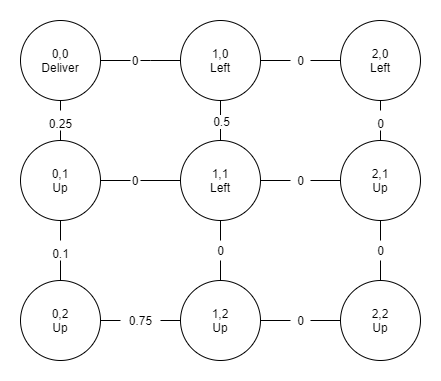

For our second set of policies we have the one where we only need to deliver to location 2,2.

The policies for these state look like this:

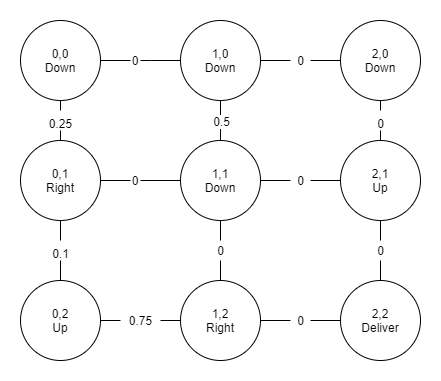


The third set of policies is for when we have to deliver to either the 0,0 delivery or 2,2 delivery. 

The policies for these state look like this:

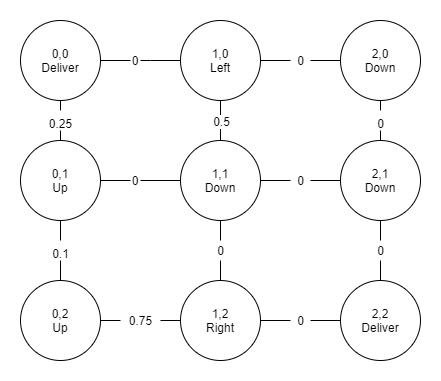